### 0.1 Case Study

#### Scenario
At BMW, we reimagine the future of mobility. Lets fast forward to 2030, and flying taxis are roaming above our cities, bringing people to
their desired destination. You work for, Duoro Hawk a company that is pioneering the world's first large fleet of fully electric, self-piloting
autonomous flying taxis. The company wants to deploy the first network of autonomous air taxis in the coming year. As part of our data
science and enginering team, you are responsible for predicting the destination of our fleet of autonomous flying taxis based on the
manned test flights that have been performed.

#### About the Dataset
A fictional dataset describing a complete year (from 01/07/2014 to 30/06/2014) of all the trajectories for all 442 of our flying taxis that
were simulated in the city of Porto. Our autonomous fleet of taxis fly from a central ground station
• There are three different types of rides: A) phone call-based, B) stand-based where people wait at a stand for their flying taxi or C) 
random place. For type A, we provide an anonymized ID, to represent the telephone call. Categories B and C refers to cases where the
taxis were directly called by the customer.

#### Dataset
##### train.csv
Each data sample corresponds to one completed trip. It contains a total of 9 (nine) features, described as follows:

- TRIP_ID: (String) It contains an unique identifier for each trip;

- CALL_TYPE: (char) It identifies the way used to demand this service. It may contain one of three possible values:
     - ‘A’ if this trip was dispatched from the central;
     - ‘B’ if this trip was demanded directly to a taxi driver on a specific stand;
     - ‘C’ otherwise (i.e. a trip demanded on a random street).
     
- ORIGIN_CALL: (integer) It contains an unique identifier for each phone number which was used to demand, at least, one service. It identifies the trip’s customer if CALLTYPE=’A’. Otherwise, it assumes a NULL value;

- ORIGINSTAND: (integer): It contains an unique identifier for the taxi stand. It identifies the starting point of the trip if CALLTYPE=’B’. Otherwise, it assumes a NULL value;

- WEATHER: (String): Information on the weather that day, unique values include: Sunny, Rainy, Cloudy, Windy, and Foggy
- TAXI_ID: (integer): It contains an unique identifier for the flying taxi that performed each trip;
- TIMESTAMP: (integer) Unix Timestamp (in seconds). It identifies the trip’s start;
- MISSING_DATA: (Boolean) It is FALSE when the GPS data stream is complete and TRUE whenever one (or more) locations are missing
- POLYLINE: (String): It contains a list of GPS coordinates (i.e. WGS84 format) mapped as a string. The beginning and the end of the string are identified with brackets (i.e. [ and ], respectively). Each pair of coordinates is also identified by the same brackets as
- [LONGITUDE, LATITUDE]. This list contains one pair of coordinates for each 15 seconds of trip. The last list item corresponds to the trip’s destination while the first one represents its start


##### test.csv
Personal records for the remaining one-third (~110) of the trips, to be used as test data. Your task is to predict the value of coordinates of the trip‘s destination

##### sample_submission.csv 
A submission file in the correct format.
- TripId - Id for each Tip in the test set
- Longitude - the longitude of the destination of the flying taxi
- Latitude – the latitude of the destination of the flying taxi

The total travel time of the trip (the prediction target of this competition) is defined as the (number of points-1) x 15 seconds. For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.

### Imports

In [57]:
%pip install awswrangler geojson scikit-learn shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 146.0 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [111]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import time
import json
import awswrangler as aw
import geojson
from shapely import geometry
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
is_sagemaker_notebook = True

In [29]:
if is_sagemaker_notebook:
    prefix = "/home/ec2-user/SageMaker"
else:
    prefix = "/Users/Q619505/PycharmProjects"

utils_path = os.path.join(f'{prefix}/ml-project-taxi-prediction/src/utils/')
pp_path = os.path.join(f'{prefix}/ml-project-taxi-prediction/src/preprocessing/')

if utils_path not in sys.path:
    sys.path.append(utils_path)

if pp_path not in sys.path:
    sys.path.append(pp_path)

In [85]:
#from utils import convert_datatypes
from geo_spatial import convert_polyline_to_geojson_format, calculate_polyline_features, haversine_distance, calculate_total_distance
from data_cleaning import filter_invalid_trips

ImportError: cannot import name 'calculate_polyline_features' from 'geo_spatial' (/home/ec2-user/SageMaker/ml-project-taxi-prediction/src/preprocessing/geo_spatial.py)

### Load Data

In [31]:
train_data = pd.read_parquet('s3://think-tank-casestudy/train_df.parquet')
test_data = pd.read_parquet('s3://think-tank-casestudy/test_df.parquet')

#### Dropping unuseful columns 
- **Unnamed: 0** column is default index and not appropriately named
- **DAY_TYPE** column is deterministic, therefore will not add any value/information gain to an ML approach

In [32]:
train_data = train_data.drop(['Unnamed: 0'], axis=1)
train_data = train_data.drop(['DAY_TYPE'], axis=1)
test_data = test_data.drop(['DAY_TYPE'], axis=1)

#### Converting column names
Converting columns names to lowercase as more appropriate to formatting standards

In [33]:
train_data.columns = [column_.lower() for column_ in train_data.columns]
test_data.columns = [column_.lower() for column_ in test_data.columns]

#### Converting datatypes 
- **TRIP_ID** object type in python is appropriate to string
- **CALL_TYPE** object type in python is appropriate to char
- **ORIGIN_CALL** integer type --> int
- **ORIGIN_STAND** object type in python is appropriate to string
- **WEATHER** object type in python is appropriate to string
- **TAXI_ID** integer type --> int
- **TIMESTAMP** Unix Timestamps --> convert to datetime timestamp
- **MISSING_DATA** boolean --> bool 
- **POLYLINE** String --> convert to geojson format for proper future processing

In [34]:
train_data = convert_polyline_to_geojson_format(data=train_data, name_column='polyline')
test_data = convert_polyline_to_geojson_format(data=test_data, name_column='polyline')

In [35]:
columns_datatypes_dict = {
    'trip_id': 'object',
    'call_type': 'object',
    'origin_call': 'object',
    'origin_stand': 'object',
    'taxi_id': 'int',
    'timestamp': 'datetime',
}

In [37]:
train_data = convert_datatypes(data=train_data.copy(), columns_datatypes_dict=columns_datatypes_dict)
test_data = convert_datatypes(data=test_data.copy(), columns_datatypes_dict=columns_datatypes_dict)

All dates are in previously defined valid ranges

In [38]:
print(train_data.timestamp.min())
print(train_data.timestamp.max())
print(test_data.timestamp.min())
print(test_data.timestamp.max())

2013-07-01 00:00:53
2014-06-30 23:59:56
2014-08-14 16:02:23
2014-12-21 14:29:19


### Sanity Checks
Assert that train and test data have same column shape
and that the trip id is in fact unique identifier of the record

In [40]:
try:
    assert(train_data.shape[1] == test_data.shape[1])
    print("Column shape train vs test passed")
    assert((train_data.columns == test_data.columns).all())
    print("Column naming train vs test passed")
    assert(train_data.trip_id.nunique() == train_data.shape[0])
    print("Check for unique trips passed - train data")
    assert(test_data.trip_id.nunique() == test_data.shape[0])
    print("Check for unique trips passed - test data")
    print('All checks passed!')
except:
    print("Sanity Check failed")

Column shape train vs test passed
Column naming train vs test passed
Sanity Check failed


### Cleaning Data
- Check showed that trip_id is not unique, so further investigation is needed
- Checking on nan/null value 
- specific cleaning tasks to the geospatial data (polyline):
    - Cleaning trips with no POLYLINE or only one coordinate point are assumed invalid and filtered from the dataset
    - Assumption that only POLYLINEs with at least 10 coordinate points are interesting 

In [46]:
vc = train_data.trip_id.value_counts().reset_index()
# get the trip ids that are duplicated
duplicated_trip_ids = vc[vc['count'] > 1]['trip_id'].unique()

print(f'{len(duplicated_trip_ids)} trip ids are duplicated')
print(f'{(len(duplicated_trip_ids)/train_data.trip_id.nunique()*100)} % out of all unique TRIPs.')

80 trip ids are duplicated
0.0046767516919610725 % out of all unique TRIPs.


In [48]:
vc_test = test_data.trip_id.value_counts().reset_index()
# get the trip ids that are duplicated
vc_test[vc_test['count'] > 1]['trip_id'].unique()

array([], dtype=object)

**Findings**:
- 159 cases
- Missing Data column is set to False for all cases
- 80 TRIP_IDs are duplicated
- Affected data is insignifcant (less than 1% of all  TRIPs)

**Assumptions**:
- Potential reasons could be cancellation by dispatcher after a person called for some reasons, failed flight attempts, broken flight taxi etc.
- The trips per ID with the longest POLYLINE are kept as these are assumed to be valid trips 
- Further investigation will should be done and analyzed together with sensor/technical data from flight taxi. Also the reason could be that a flight is interrupted and re-started again, that could be analyzed by plotting the POLYLINE and compare the start and end point of the duplicated TRIPs. Will be part of further optimization

#### NAN/Null Missing values

In [55]:
train_data.isnull().sum()

trip_id               0
call_type             0
origin_call     1345900
origin_stand     904091
taxi_id               0
timestamp             0
missing_data          0
polyline              0
weather               0
dtype: int64

In [54]:
test_data.isnull().sum()

trip_id           0
call_type         0
origin_call     248
origin_stand    197
taxi_id           0
timestamp         0
missing_data      0
polyline          0
weather           0
dtype: int64

ORIGIN_CALL and ORIGIN_STAND have null values which is to be expected as they are determined dependent on the call type

#### Data Cleaning POLYLINE
To do cleaning regarding the POLYLINE, a few more attributes are calculated:
- **n_coordinate_points** - number of total points
- **total_flight_time_seconds, total_flight_time_minutes** - flight time total
- **start_point** - Starting point for each trip
- **dest_point** - Last point for each trip 
- **total_distance** - total distance of trip in km with haversine formulam

In [75]:
train_data = calculate_polyline_features(train_data)
test_data = calculate_polyline_features(test_data)

Based on assumption, keeping only polylines with at least 10 coordinate points

In [82]:
train_data = filter_invalid_trips(train_data, n_points=10)
test_data = filter_invalid_trips(test_data, n_points=10)

Calculating the total distance of the trip in km

In [94]:
import geojson
import pandas as pd
from sklearn.metrics.pairwise import haversine_distances
from math import radians


In [95]:
def haversine_distance(lat1, lat2, lon1, lon2) -> float:
    """
    :param lat1: Latitude of first point
    :param lat2: Latitude of second point
    :param lon1: Longitude of first point
    :param lon2: Longitude of second point
    :return: Method returns haversine distance between geo coordinates of two points
    """
    # analog to following source -> https://scikit-
    # learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html

    point_1 = [lon1, lat1]
    point_2 = [lon2, lat2]
    point1_in_radians = [radians(_) for _ in point_1]
    point2_in_radians = [radians(_) for _ in point_2]
    result = haversine_distances([point1_in_radians, point2_in_radians])
    result = result * 6371000 / 1000
    return result[0][1]

In [96]:
def calculate_total_distance(data) -> pd.DataFrame:
    modified_data = data.copy()
    modified_data["start_point"] = modified_data["polyline"].apply(
        lambda value: value[0]
    )
    modified_data["dest_point"] = modified_data["polyline"].apply(
        lambda value: value[-1]
    )
    modified_data["total_distance_km"] = modified_data.apply(
        lambda row: haversine_distance(
            lat1=row.start_point[1],
            lat2=row.dest_point[1],
            lon1=row.start_point[0],
            lon2=row.dest_point[0],
        ),
        axis=1,
    )
    return modified_data

In [97]:
train_data = calculate_total_distance(train_data)
test_data = calculate_total_distance(test_data)

In [99]:
train_data['sequence'] = train_data.polyline.apply(lambda row: np.hstack(row))
test_data['sequence'] = test_data.polyline.apply(lambda row: np.hstack(row))

In [100]:
train_data = train_data.drop(['polyline'], axis=1)
test_data = test_data.drop(['polyline'], axis=1)

#### Missing data columm

In [103]:
print(f'Train Data: {train_data.missing_data.value_counts()} Trips with missing_data == True')

Train Data: missing_data
False    1641024
True           8
Name: count, dtype: int64 Trips with missing_data == True


In [104]:
print(f'Test Data: {test_data.missing_data.value_counts()} Trips with missing_data == True')

Test Data: missing_data
False    269
Name: count, dtype: int64 Trips with missing_data == True


In [105]:
train_data[train_data.missing_data == True]

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,missing_data,weather,n_coordinate_points,total_flight_time_seconds,total_flight_time_minutes,start_point,dest_point,total_distance_km,sequence
105621,1374554455620000625,B,NaN,23.0,20000625,2013-07-23 04:40:55,True,Sunny,43,630,10.50,"[-8.612559, 41.145975]","[-8.603307, 41.124177]",2.608008,"[-8.612559, 41.145975, -8.612577, 41.145975, -..."
299137,1378544246620000057,B,NaN,55.0,20000057,2013-09-07 08:57:26,True,Rainy,11,150,2.50,"[-8.569719, 41.166135]","[-8.555976, 41.277636]",12.355013,"[-8.569719, 41.166135, -8.567928, 41.166477, -..."
457486,1381233613620000387,C,NaN,NaN,20000387,2013-10-08 12:00:13,True,Foggy,483,7230,120.50,"[-8.626347, 41.153436]","[-8.643879, 41.158908]",2.040173,"[-8.626347, 41.153436, -8.626275, 41.152905, -..."
738466,1386346894620000904,C,NaN,NaN,20000904,2013-12-06 16:21:34,True,Rainy,285,4260,71.00,"[-8.652816, 40.636575]","[-7.990911, 41.337756]",106.623590,"[-8.652816, 40.636575, -8.652807, 40.636566, -..."
782321,1387137779620000640,C,NaN,NaN,20000640,2013-12-15 20:02:59,True,Rainy,51,750,12.50,"[-8.604558, 41.161941]","[-8.653482, 41.174937]",5.624586,"[-8.604558, 41.161941, -8.604477, 41.162013, -..."
848552,1388351478620000678,A,9738.0,NaN,20000678,2013-12-29 21:11:18,True,Rainy,27,390,6.50,"[-8.609697, 41.160276]","[-8.629848, 41.151492]",2.439933,"[-8.609697, 41.160276, -8.609571, 41.16033, -8..."
932391,1390005983620000640,C,NaN,NaN,20000640,2014-01-18 00:46:23,True,Rainy,14,195,3.25,"[-8.604792, 41.16123]","[-8.611047, 41.149485]",1.466677,"[-8.604792, 41.16123, -8.604801, 41.161167, -8..."
1432196,1399405185620000508,C,NaN,NaN,20000508,2014-05-06 19:39:45,True,Rainy,53,780,13.00,"[-8.620011, 41.14683]","[-8.578656, 41.145696]",4.600156,"[-8.620011, 41.14683, -8.619957, 41.146659, -8..."


- Amount of data with missing values insignificant compared to total amount of data
- Majority of trips is WEATHER == Rainy, however total amount of trips is not significant enought to draw a conclusion/make an assumption
- Number of points/length of polyline is in general unequal so there is no indication in that sense how much data is missing, also no information if data is missing at the start/middle or end of POLYLINE 

Based on these Findings, I would simply drop these values, mainly as their effect is expected to be very little. If the number of data samples would be higher, I would try to impute the missing coordinates in this case with the Nearest Neighbour. However the problem of knowing if the cooordinates are missing in start/middle/end would prevail. In case I find very similar trips through additional logic (difference in n_coordinate_points <= 5 and overall_distance between points < threshold) I could minimize this problem. These tasks could be part of further optimization.

In [106]:
train_data = train_data[train_data.missing_data != True]

#### OUTLIER
To handle the outliers, we look at statistical indicators and plot the boxplot.

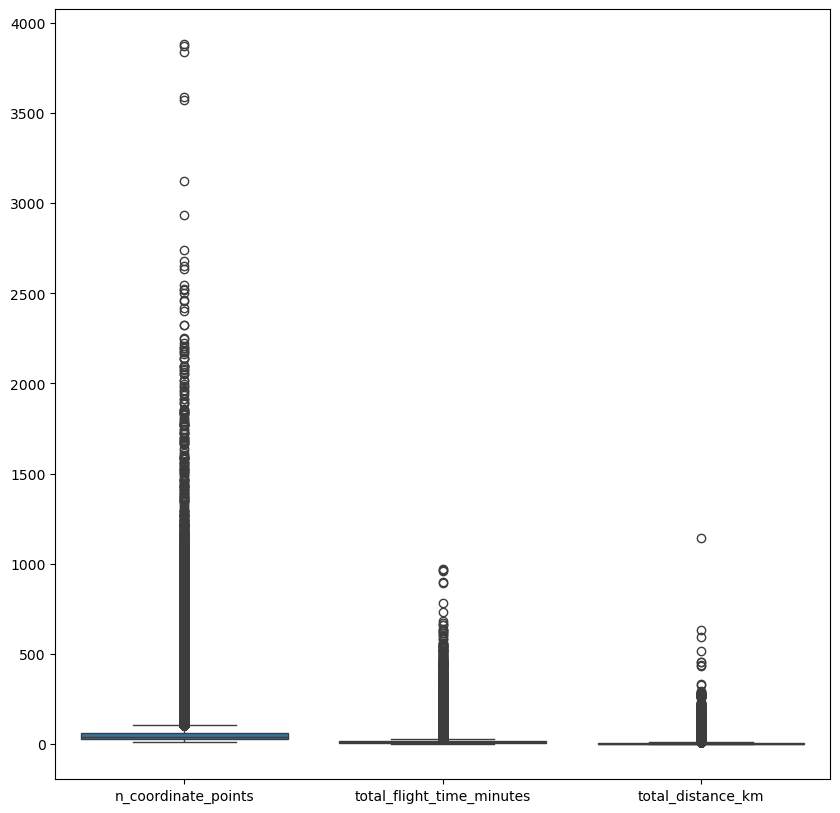

In [112]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=train_data[['n_coordinate_points','total_flight_time_minutes','total_distance_km']])
plt.show()

The cotinous attributes show a high number of outliers, with the number of coordinate points the widest spread.
To avoid loosing too much data, keeping the 95% quantile of the data regarding the N_COORDINATE_POINTS and TOTAL_DISTANCE seems to be the best choice. 

In [113]:
train_data = train_data[(train_data.n_coordinate_points <= train_data.n_coordinate_points.quantile(0.90))
                 & (train_data.total_distance_km <= train_data.total_distance_km.quantile(0.90))]

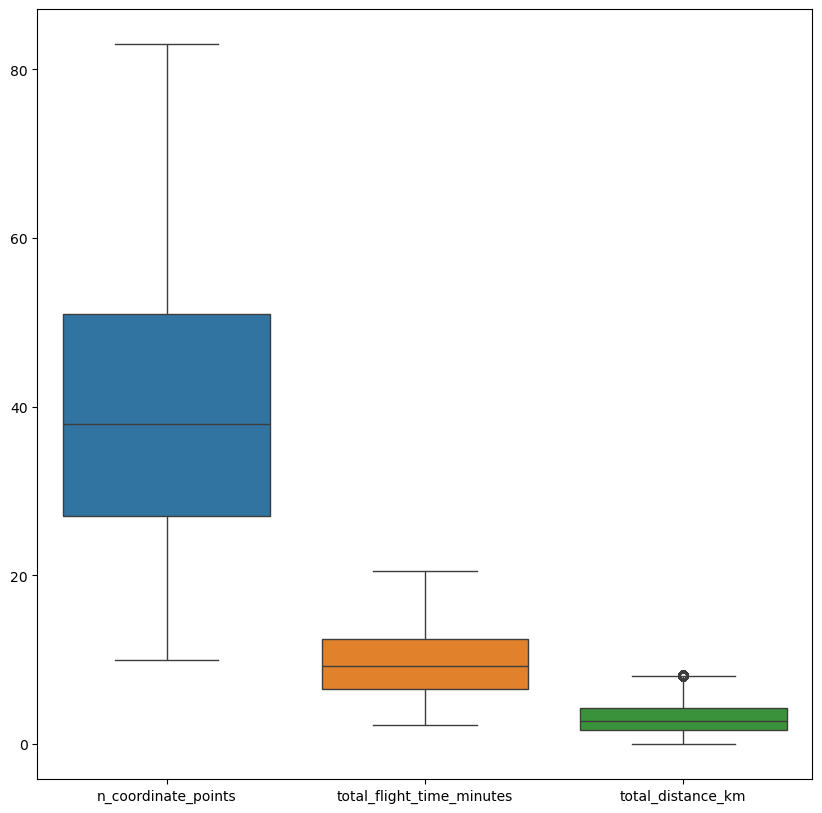

In [114]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=train_data[['n_coordinate_points','total_flight_time_minutes','total_distance_km']])
plt.show()

We can see some outliers remaining, however the spread is significantly reduced. Outliers in the test data will be kept to avoid too much reduction.

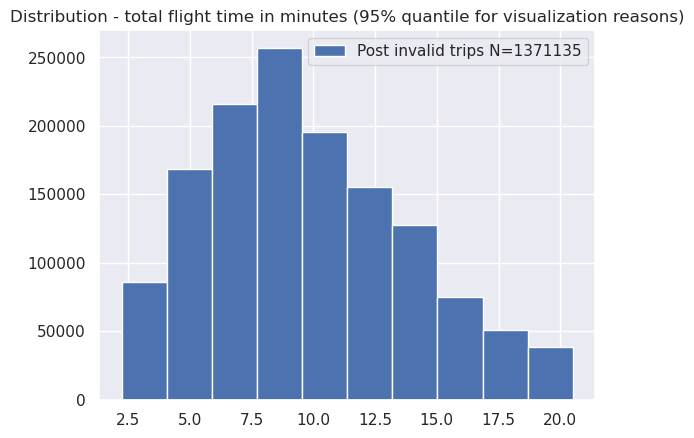

In [115]:
sns.set()
plt.hist(train_data.total_flight_time_minutes,
         label=f'Post invalid trips N={train_data.shape[0]}')
plt.title('Distribution - total flight time in minutes (95% quantile for visualization reasons)')
plt.legend()
plt.show()

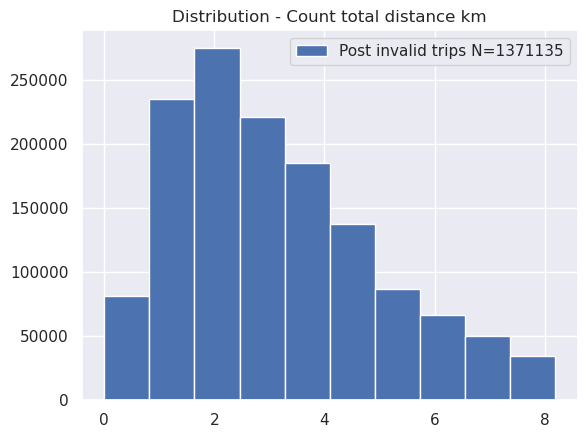

In [116]:
sns.set()
plt.hist(train_data.total_distance_km,
         label=f'Post invalid trips N={train_data.shape[0]}')
plt.title('Distribution - Count total distance km')
plt.legend()
plt.show()

The reduction of the training data does not have a major effect on the data distribution. Optimization could be to compare performance with/without outliers 

In [118]:
try:
    assert(train_data.shape[1] == test_data.shape[1])
    print("Column shape train vs test passed")
    assert((train_data.columns == test_data.columns).all())
    print("Column naming train vs test passed")
    assert(train_data.trip_id.nunique() == train_data.shape[0])
    print("Check for unique trips passed - train data")
    assert(test_data.trip_id.nunique() == test_data.shape[0])
    print("Check for unique trips passed - test data")
    print('All checks passed!')
except:
    print("Sanity Check failed")

Column shape train vs test passed
Column naming train vs test passed
Check for unique trips passed - train data
Check for unique trips passed - test data
All checks passed!


#### 0.5.5 CALL_TYPE LOGIC

In [121]:
def check_call_type(data):
    data_A = data[(data.call_type == 'A') & (data.origin_call == np.NaN)]
    data_B = data[(data.call_type == 'B') & (data.origin_stand == np.NaN)]
    data_C = data[(data.call_type == 'C') & (data.origin_stand != np.NaN)].origin_stand.nunique()
    return data_A, data_B, data_C

In [122]:
check_call_type(train_data)

(Empty DataFrame
 Columns: [trip_id, call_type, origin_call, origin_stand, taxi_id, timestamp, missing_data, weather, n_coordinate_points, total_flight_time_seconds, total_flight_time_minutes, start_point, dest_point, total_distance_km, sequence]
 Index: [],
 Empty DataFrame
 Columns: [trip_id, call_type, origin_call, origin_stand, taxi_id, timestamp, missing_data, weather, n_coordinate_points, total_flight_time_seconds, total_flight_time_minutes, start_point, dest_point, total_distance_km, sequence]
 Index: [],
 0)

In [123]:
check_call_type(test_data)

(Empty DataFrame
 Columns: [trip_id, call_type, origin_call, origin_stand, taxi_id, timestamp, missing_data, weather, n_coordinate_points, total_flight_time_seconds, total_flight_time_minutes, start_point, dest_point, total_distance_km, sequence]
 Index: [],
 Empty DataFrame
 Columns: [trip_id, call_type, origin_call, origin_stand, taxi_id, timestamp, missing_data, weather, n_coordinate_points, total_flight_time_seconds, total_flight_time_minutes, start_point, dest_point, total_distance_km, sequence]
 Index: [],
 0)

In [125]:
train_data.drop(['timestamp','missing_data','total_flight_time_seconds'], axis=1, inplace=True)
test_data.drop(['timestamp','missing_data','total_flight_time_seconds'], axis=1, inplace=True)

/tmp/ipykernel_30373/2380197590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['timestamp','missing_data','total_flight_time_seconds'], axis=1, inplace=True)


In [126]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1371135 entries, 0 to 1710669
Data columns (total 12 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   trip_id                    1371135 non-null  object 
 1   call_type                  1371135 non-null  object 
 2   origin_call                298391 non-null   object 
 3   origin_stand               689054 non-null   object 
 4   taxi_id                    1371135 non-null  int64  
 5   weather                    1371135 non-null  object 
 6   n_coordinate_points        1371135 non-null  int64  
 7   total_flight_time_minutes  1371135 non-null  float64
 8   start_point                1371135 non-null  object 
 9   dest_point                 1371135 non-null  object 
 10  total_distance_km          1371135 non-null  float64
 11  sequence                   1371135 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 136.0+ MB


In [127]:
aw.s3.to_parquet(df=train_data, path='s3://think-tank-casestudy/preprocessed_data/train_data_preprocess.parquet')
aw.s3.to_parquet(df=test_data, path='s3://think-tank-casestudy/preprocessed_data/test_data_preprocess.parquet')

{'paths': ['s3://think-tank-casestudy/preprocessed_data/test_data_preprocess.parquet'],
 'partitions_values': {}}